## Nonlinear Elastic Phase Field Fracture 

In this tutorial, we model the deformation and fracture of nonlinear elastic materials using FEniCSx. 

Consider a 2D beam $\Omega = \{(x,y): x\in (0, L),\; y\in (0,W)\}$. The beam is fixed on the left edge (at $ x=0 $),  $\Gamma_l = \{(x,y) \in \Omega: x = 0\}$, and is subjected to a prescribed displacement $\boldsymbol{u_D}$ on the right surface (at $x=L$), $\Gamma_r = \{(x,y) \in \Omega: x = L\}$. 

In this model it can be assumed that the base material is hyperelastic, homogeneous, isotropic, brittle material, and any inclusions can be assumed to be elastic, homogeneous, isotropic, brittle material. 

\begin{equation}
    \mathcal{E}_{tot}(u,\alpha) = \mathcal{E}_{elas}(u,\alpha)+\mathcal{E}_{frac}(\alpha)-\mathcal{W}_{ext}(u)
\end{equation}
Where the elastic and fracture energy along with the external work are described as. 
\begin{equation}
    \mathcal{E}_{elas}(u,\alpha) = \int_{\Omega} a(\alpha)W(F)dx
\end{equation}
\begin{equation}
    \mathcal{E}_{frac}(\alpha) = \frac{G_c}{4*c_w} \int_{\Omega} \frac{w(\alpha)}{l} + l ||\nabla\alpha||^2dx
\end{equation}
\begin{equation}
    \mathcal{W}_{ext}(u)= \int_{\Omega}f\cdot u dx
\end{equation}
Where $W(F)$ is the strain energy density, which for this case is a compressible Neo-Hookean model. 
\begin{equation}
    W(F) = \frac{\mu}{2}*(\mathcal{I}_c -3- 2*ln(J)) + \frac{\lambda}{2}(J-1)^2
\end{equation}
Where, $\mu$ and $\lambda$ are Lam\'{e} parameters which are dependent on Young's modulus $E$ and Poisson's ratio $\nu$, $\mathcal{I}_c$ is an invariant dependent on $C$ which is the Right Cauchy Green tensor, $J$ is the Jacobian dependent on $F$ which is the deformation gradient, $I$ is the identity matrix, and T represents the transpose. 
\begin{equation}
    \mu = \frac{E}{2(1+\nu)}, \quad
    \lambda = \frac{E\nu}{(1-\nu ^2)}
\end{equation}
\begin{equation}
    F(u) = I + \nabla u    
\end{equation}
\begin{equation}
    \mathcal{I}_c(C) = tr(C), \quad
    C = F^TF
\end{equation}
\begin{equation}
    J = det(F)
\end{equation}

### Variational Statement 
Let $ V_u $ be the appropriate function space for the displacement (functions in $ V_u $ are vector-valued functions). Due to homogeneous Dirichlet boundary condition, the trial and test functions belong to the same function space.Multiplying the strong form of the problem by test function $ v_u $ and integrating it over the domain $ \Omega $ gives:

\begin{equation}
    \delta(\mathcal{E}_{tot}(u,\alpha;v_u) = 0 
\end{equation}
Resulting in the following variational statement for the displacement, 
\begin{equation}
    \delta(\mathcal{E}_{tot}(u,\alpha;v_u) = \int_{\Omega} a(\alpha)P: \nabla (v_u) dx - \int_{\Omega} f \cdot v_u dx  
\end{equation}

Where $ P $ is the first Piola-Kirchoff stress $ ( P = \partial W / \partial F) $ 

Let $ V_{\alpha} $ be the appropriate function space for the displacement (functions in $ V_{\alpha} $ are vector-valued functions). Due to homogeneous Dirichlet boundary condition, the trial and test functions belong to the same function space.Multiplying the strong form of the problem by test function $ v_{\alpha} $ and integrating it over the domain $ \Omega $ gives:

\begin{equation}
    \delta(\mathcal{E}_{tot}(u,\alpha; v_{\alpha}) = 0 
\end{equation}
Resulting in the following variational statement for the damage, 
\begin{equation}
    \delta(\mathcal{E}_{tot}(u,\alpha; v_{\alpha}) = \int_{\Omega} a'(\alpha0 W(F) v_{\alpha} + (G_c/4c_w) \int_{\Omega} ((w'(\alpha)/l) v_{\alpha} + 2l \nabla \alpha \cdot \nabla v_{\alpha}) dx
\end{equation}

### Geometrical, material, and external loading parameters and functions
In what follows, we let $ L = 1 mm $ and $ H = 0.3 mm $. We assume that there is no applied body force, i.e., $ f = 0 $. The prescribed displacement $ \boldsymbol u_D = 0.67278 mm $ applied on the x-direction only on the right edge $ \Gamma_r $. 

As for the material properties, we take Young's modulus $E = 1.84 MPa $, Poisson ratio $\nu = 0.3 $, critical fracture energy $ G_c = 0.0489  N/mm $. These properties are typical of rubber-like materials. 

The second material property is a metallic material which is included for cases with two materials, such as inclusions or a split material bar. The matrial properties, we take Young's modulus $ E = 1600000 MPa $, Poisson ratio $ \nu = 0.24 $, critical fracture energy $ G_c = 0.189 N/mm $. 

### Solving Process 
As mentioned above the loading is a prescribed displacement the displacement is applied in steps. The problem is solved in an alternate minimization process where, first the displacment is solved for at a fixed phase-field (damage), then the damage is solved for at a fixed displacement. 

### References
George, D., Konica, S., Masters, I., & Hossain, M. (2025). A phase field formulation for modelling fracture of nearly incompressible hyperelastic materials. Computer Methods in Applied Mechanics and Engineering, 436, 117696.  
---This paper contains the energy functional for the problem used in this tutorial. 

Hale, J. S., & Maurini, C. (2020). NewFrac FEniCSx Training. Jupyter Book. Retrieved from https://newfrac.gitlab.io/newfrac-fenicsx-training/  
--- This repository covers a method for the phase field fracture method in FEniCSx. 


#### FEniCSx implementation 
We start by loading in the relavent packages. The solvers, func, form_prob, and bound_cond are located in the deps folder and need to be downloaded into the same folder as the .ipynb file to run. 

In [1]:
# dolfinx from the fenicx library with specific functions 
import dolfinx 
from dolfinx import mesh, fem, plot, io, la 
import dolfinx.fem.petsc
import petsc4py
from petsc4py import PETSc
from dolfinx.io import gmshio
import gmsh

# mpi4py for parallel execution 
import mpi4py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# scientific computation and math 
import ufl 
import numpy as np 
import sympy

# plotting and visualization 
import matplotlib.pyplot as plt
import pyvista 

import sys
import os 
from typing import Optional

#specific functions from supporting modules 
from solvers import LinearSolver, AlphaSolver
from func import create_functions, AltMin, MeshPlotter, material_properties, unpack_functions
from form_prob import form_prob
from bound_cond import prescribed_disp_x, prescribed_disp_y

Next, we create a results directory. 

In [2]:
# Results folder labeled for the geometry of the model and the direction of loading 
results_folder = "pfm_result/notched_hyp_x"
if rank == 0: 
    os.makedirs(results_folder, exist_ok=True)

Now, the model and the mesh are created using the gmsh library.

In [3]:
gmsh.initialize()

# Creates and names the model 
gmsh.model.add("notched_hyp")

# Build geometry
# Creates points at the verticies of the model 
gmsh.model.occ.addPoint(0, 0, 0, 0.1, 1)
gmsh.model.occ.addPoint(1, 0, 0, 0.1, 2)
gmsh.model.occ.addPoint(1, 0.3, 0, 0.1, 3)
gmsh.model.occ.addPoint(0, 0.3, 0, 0.1, 4)
gmsh.model.occ.addPoint(0.255, 0, 0, 0.1, 5)
gmsh.model.occ.addPoint(0.265, 0, 0, 0.1, 6)
gmsh.model.occ.addPoint(0.26, 0.03, 0, 0.1, 7)
# Creates the lines that connect the vertices of the model 
gmsh.model.occ.addLine(1, 5, 1)
gmsh.model.occ.addLine(5, 7, 2)
gmsh.model.occ.addLine(7, 6, 3)
gmsh.model.occ.addLine(6, 2, 4)
gmsh.model.occ.addLine(2, 3, 5)
gmsh.model.occ.addLine(3, 4, 6)
gmsh.model.occ.addLine(4, 1, 7)
gmsh.model.occ.addLine(1, 2, 8)
# Creates the curve loop used to define the plane surface 
gmsh.model.occ.addCurveLoop([1, 2, 3, 4, 5, 6, 7], 1)
# Creates the plane surface of the model
gmsh.model.occ.addPlaneSurface([1], 1)

gmsh.model.occ.synchronize()

# Adds physical groups
gmsh.model.addPhysicalGroup(2, [1], 1)  # Group for 2D surface 
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4, 5, 6, 7], 6)  # Group for 1D boundary lines 

# Gets the boundaries and creating boundary arrays 
boundary = gmsh.model.getBoundary([(2, 1)], oriented=False)
xBot, xTop, yBot, yTop = [], [], [], []
for dim, tag in boundary:
    x, y, _ = gmsh.model.occ.getCenterOfMass(dim, tag)
    if np.isclose(x, 0.0, atol=1e-6):
        xBot.append(tag)
    elif np.isclose(x, 1.0, atol=1e-6):
        xTop.append(tag)
    elif np.isclose(y, 0.0, atol=1e-6):
        yBot.append(tag)
    elif np.isclose(y, 0.3, atol=1e-6):
        yTop.append(tag)    

# Adds physical groups for boundary conditions 
gmsh.model.addPhysicalGroup(1, xBot, 2)
gmsh.model.setPhysicalName(1, 2, "xBot")
gmsh.model.addPhysicalGroup(1, xTop, 3)
gmsh.model.setPhysicalName(1, 3, "xTop")
gmsh.model.addPhysicalGroup(1, yTop, 4)
gmsh.model.setPhysicalName(1, 4, "yTop")
gmsh.model.addPhysicalGroup(1, yBot, 5)
gmsh.model.setPhysicalName(1, 5, "yBot")

# Sets the regularization length scale range 
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.01)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.015)

# Generates the mesh 
gmsh.model.mesh.generate(2)
gmsh.write("notched_rectangle_hyp.msh")
print("Mesh Written")

# Converts to dolfinx mesh
domain, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, comm=MPI.COMM_WORLD, rank=0, gdim=2)
print("Mesh Imported")

gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00358645s, CPU 0.00556s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.219465s, CPU 0.21657s)
Info    : 1846 nodes 3632 elements
Info    : Writing 'notched_rectangle_hyp.msh'...
Mesh Written
Info    : Done writing 'notched_rectangle_hyp.msh'
Mesh Imported


Next, we create the domain topology and the connectivity. Additionally, we run the MeshPlotter to visualize the mesh. 

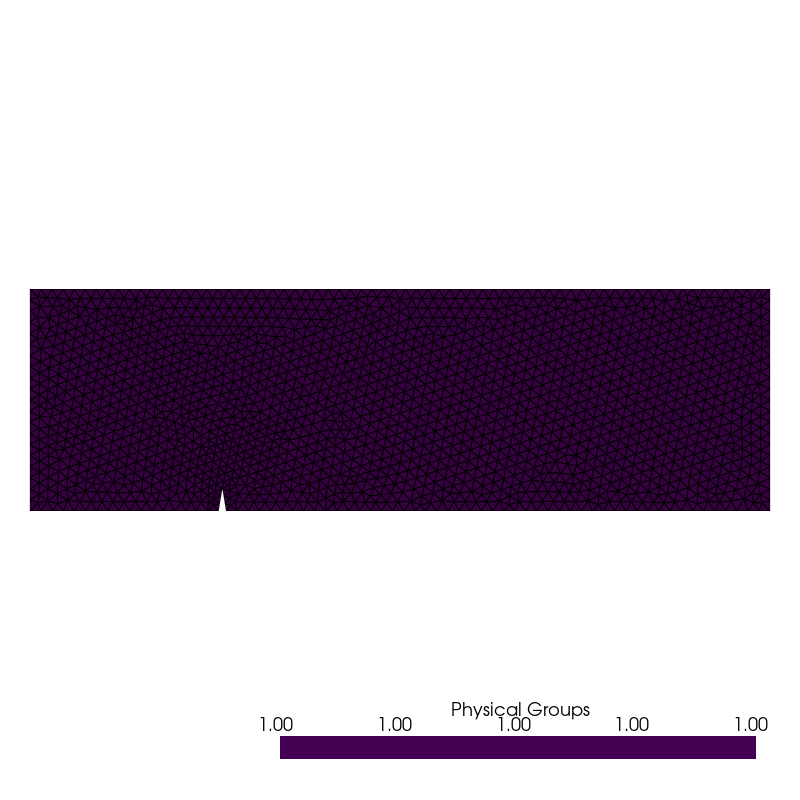

In [4]:
# Creates the domain topology and the connectivity
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, tdim)

# Plots the geometry and mesh 
plotter = MeshPlotter(domain, tdim, cell_tags)
plotter.plot()

Then we define the material properties, and the dimesions of the model. 

In [5]:
omega_L, omega_H = 1.0, 0.3 #mm
# material_1 = {"E1": 7000, "Gc1": 5.497e-6, "nu1": 0.2} 
# # E: Mpa, Gc: N/mm, nu: unitless
# material_2 = {"E2": 50000, "Gc2": 1.886, "nu2":0.2}
material_1 = {"E1": 1.84, "Gc1": 0.0489, "nu1": 0.3}
# E: Mpa, Gc: N/mm, nu: unitless
material_2 = {"E2": 1600000, "Gc2": 0.189, "nu2":0.24}
top_tag = 1

properties = material_properties(material_1, material_2, domain, cell_tags, top_tag)

Tag 1 has 3379 cells


In [6]:
matl_type = {"hyperelastic": True, "hypermodel": "neoHookean2"} # Selects the material model type and the energy functional  

#Setting initial values fo later calculations 
ell_ = 0.01 # Characteristic Length 
E_0 = fem.Constant(domain, PETSc.ScalarType(material_1["E1"])) # Young's modulus
Gc_0 = fem.Constant(domain, PETSc.ScalarType(material_1["Gc1"])) # Critical fracture energy 

conditions = {"E_0": E_0, "Gc_0": Gc_0, "ell_": ell_}

Then the test and trial functions and funciton spaces are created for both the displacement and damage variables. 

In [7]:
state, spaces, bounds, dx, ds = create_functions(domain)

u, alpha, alpha_low, alpha_up, V_u, V_alpha = unpack_functions(state, spaces, bounds)

The boundary conditions and initital loading are then created using the bound_cond module. The loading is a prescribed displacement.

In [8]:
bcu, bcalpha, u_D = prescribed_disp_x(domain, V_u, V_alpha, facet_tags) # Establishes the boundary conditions and the loading 
bcs = {"bcu": bcu, "bcalpha": bcalpha} # Dictionary of combined boundary conditions 

Now we create the total energy functional, the initial guess for the loading, and establish the displacemnt and damage solvers.

In [9]:
total_energy, init, solver_u, solver_alpha = form_prob(state, conditions, properties, tdim, dx, domain, matl_type, spaces, bcs, bounds)

c_w =  2
ell =  0.01
init =  8.580249585847184e-05


In [10]:
#Creates a folder and sets up the ability to write the displacement and the damage to .bp file readable in parview
filename = results_folder + "/solution"
file_results = io.VTXWriter(domain.comm, filename + ".bp", [u,alpha], engine="BP4")

Then, we apply the prescribed displacement in increments to the model. 

In [ ]:
#!!Unchanged from fenicsx-fracture!! alpha_low us renamed for clarity
load0 = float(init)*omega_L # reference value for the loading (imposed displacement)
loads = load0*np.linspace(0, 7841, 500)

energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))

alt_min_parameters = {"atol": 1.e-6,"max_iter": 100}
alt_min = AltMin(state, alt_min_parameters, dx, solver_u, solver_alpha, file_results)

with u.x.petsc_vec.localForm() as x_local:
    x_local.set(0)
with alpha.x.petsc_vec.localForm() as alpha_local:
    alpha_local.set(0)

for i_t, t in enumerate(loads):
    u_D.value = t
        
    alt_min.set_load(t)
    # update the lower bound
    alpha.x.petsc_vec.copy(alpha_low.x.petsc_vec)    
    print(f"-- Solving for t = {t:3.2f} --")
    alt_min.alternate_minimization(parameters=alt_min_parameters, monitor=alt_min.monitor)
    file_results.write(i_t)

-- Solving for t = 0.00 --
Load: 0.000000e+00, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 0.0000e+00, min(u) = 0.0000e+00
-- Solving for t = 0.00 --
Load: 1.348251e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 1.3483e-03, min(u) = 0.0000e+00
-- Solving for t = 0.00 --
Load: 2.696502e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 2.6965e-03, min(u) = 0.0000e+00
-- Solving for t = 0.00 --
Load: 4.044754e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 4.0448e-03, min(u) = 0.0000e+00
-- Solving for t = 0.01 --
Load: 5.393005e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.0000e+00
  max(u) = 5.3930e-03, min(u) = 0.0000e+00
-- Solving for t = 0.01 --
Load: 6.741256e-03, Iteration:   0, Error: 0.0000e+00
  max(alpha) = 0.0000e+00, min(alpha) = 0.00

### Results 
The results file is a .bp file which is readable in paraview version 5.11.2. To plot, open a paraview app and drag the folder solution.bp in the box Pipieline Browser on left side of paraview app. Next, select the Warp by Vector from the Filters menu to add displacement to the reference configuration to get the current configuration. Next, select the von Mises stress from the plot field selector. The results are viewed by adjusting the coloring tab to either damage or displacement, and setting the automatic rescale range mode to clamp and update at every timestep.  

#### Displacement Results (mm)
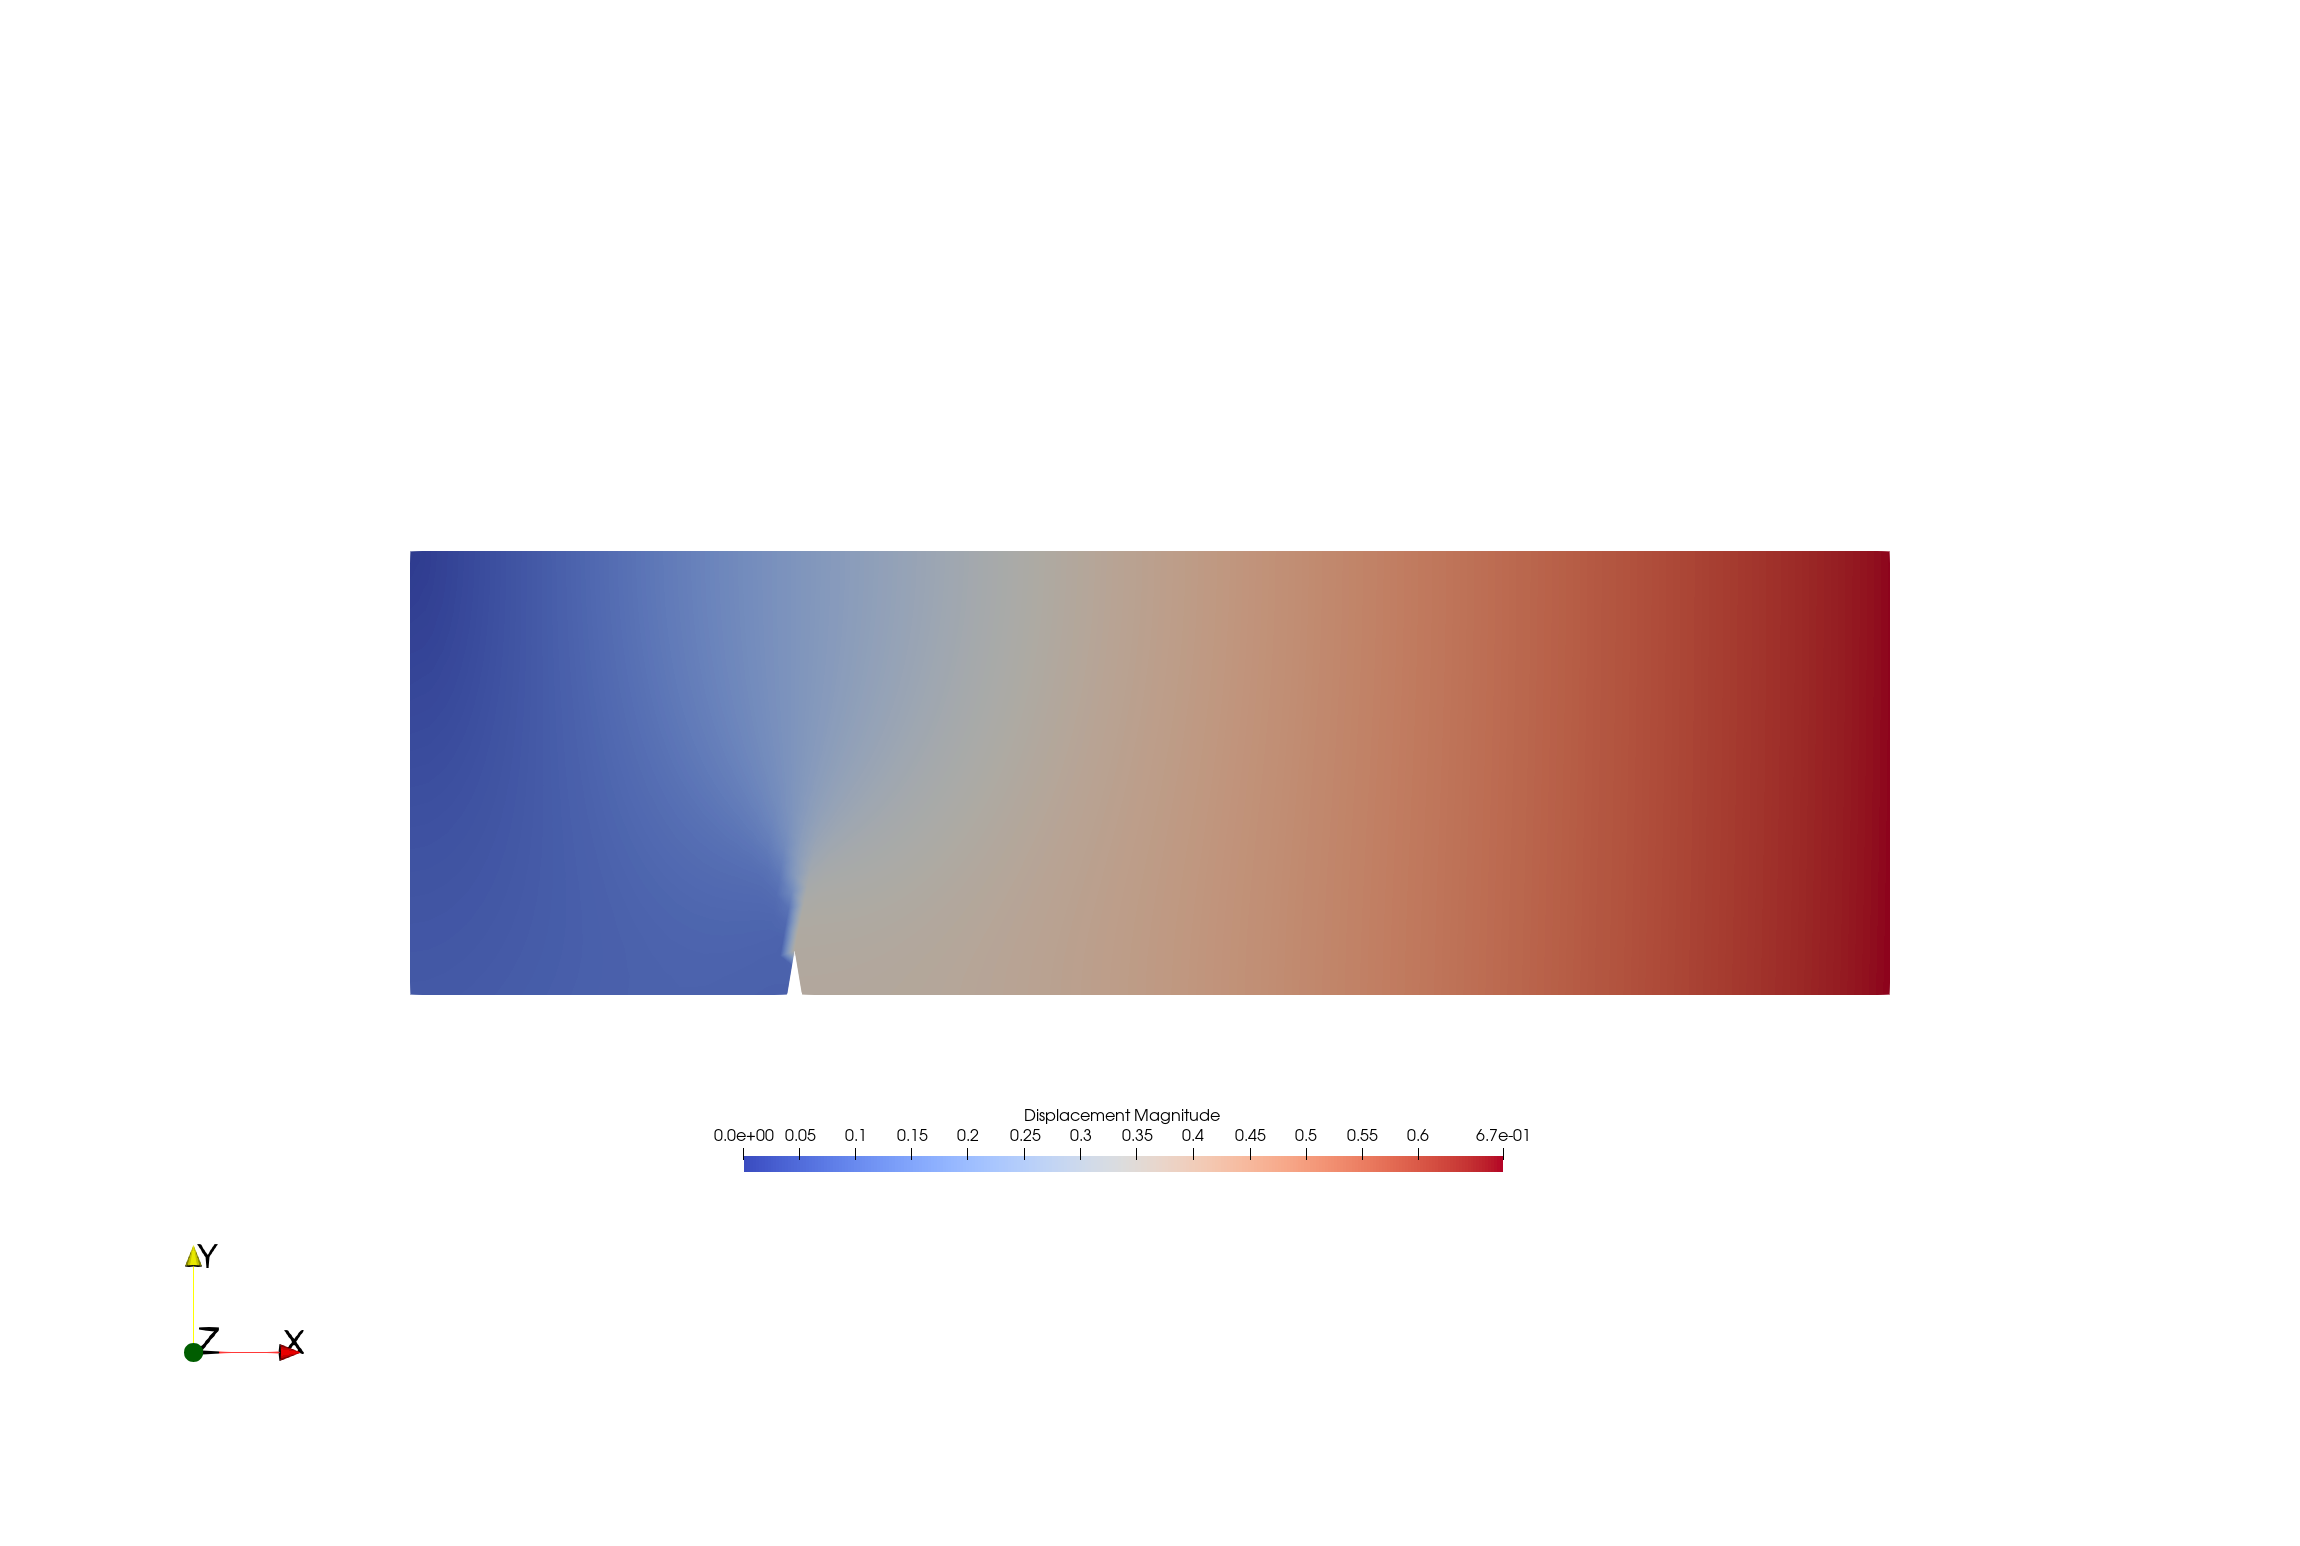

#### Damage Result (alpha)
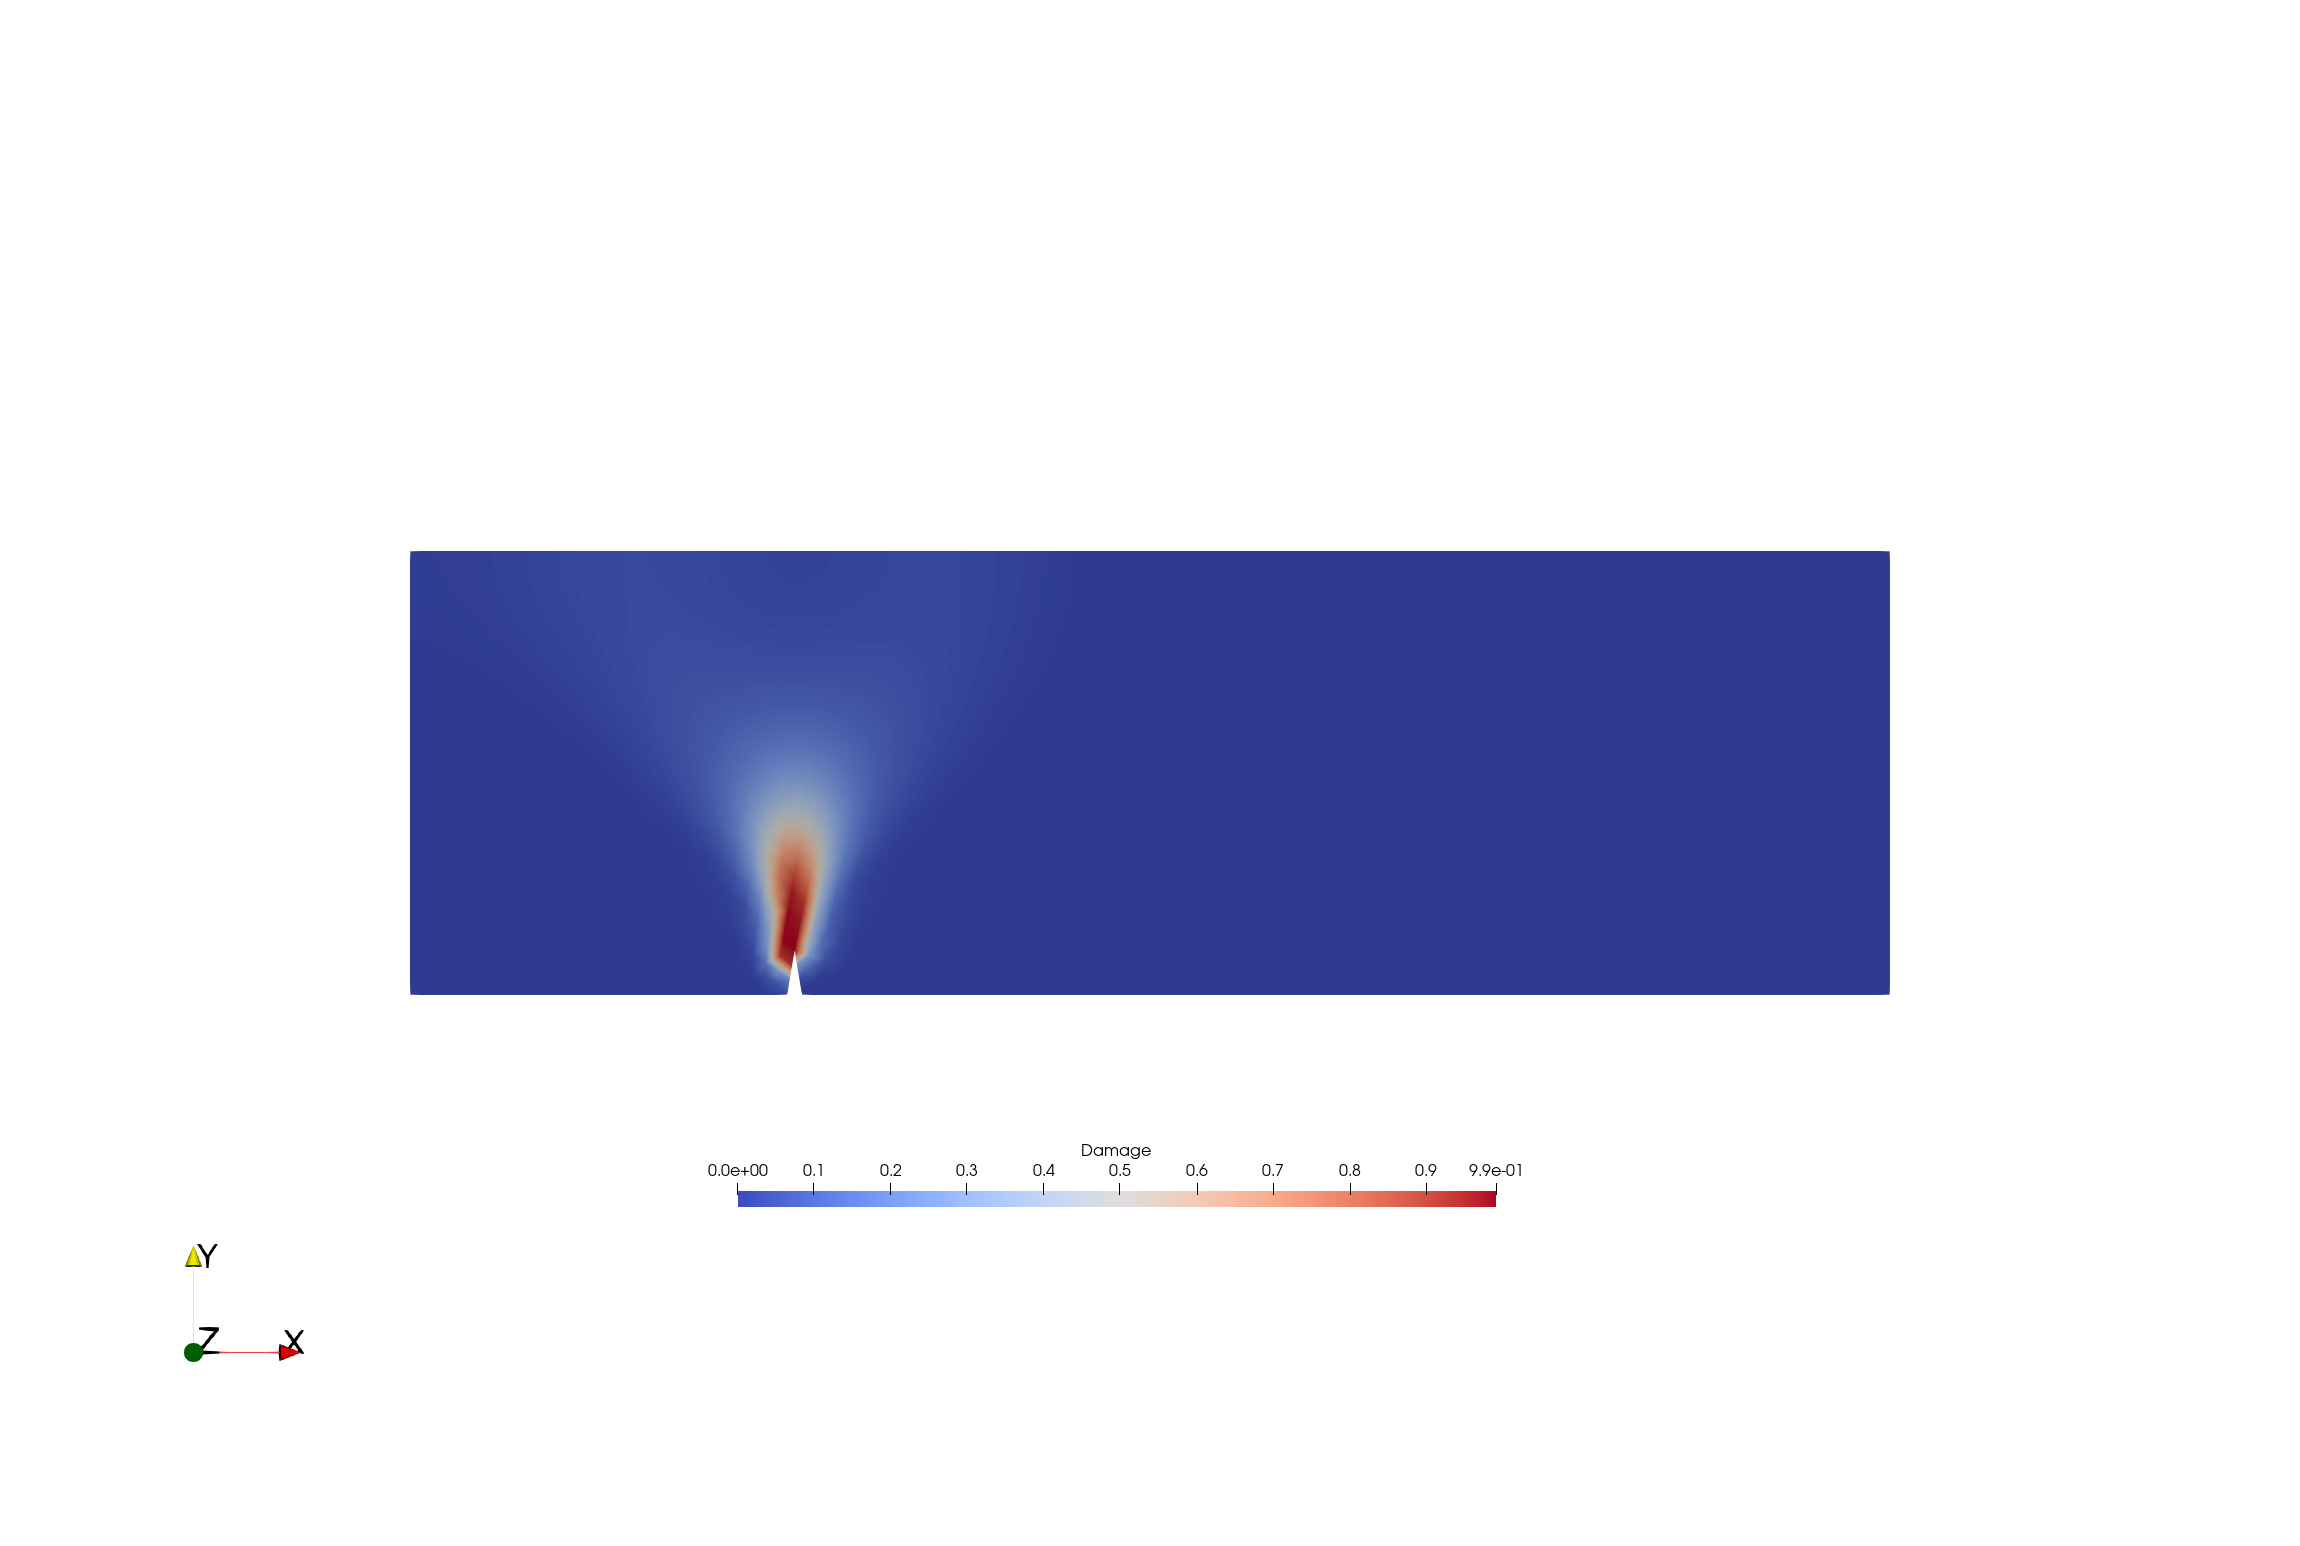